# Quant Project #

## Financial Market Information ##

In [23]:
import financedatabase as fd
import pandas as pd
import numpy as np
from functools import lru_cache
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
import yfinance as yf
import datetime
from datetime import datetime
yf.pdr_override()
equities = fd.Equities()

import panel as pn
pn.extension()

# ML libraries
import itertools
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

#import .py module
import trading

# Alpaca API
import requests
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import MarketOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce

# Sector
equities_US_sector = equities.options('sector', country='United States')
sector_dataframe=pd.DataFrame(equities_US_sector, columns=['Sector'])

# Industry Group
equities_US_industry_group = equities.options('industry_group', country='United States')
industry_group_dataframe=pd.DataFrame(equities_US_industry_group, columns=['Industry Group'])

# Industry
equities_US_industry = equities.options('industry', country='United States')
industry_dataframe=pd.DataFrame(equities_US_industry, columns=['Industry'])

# Exchanges
equities_US_exchange = np.array(['NYQ', 'PNK', 'NMS', 'ASE', 'NGM', 'NCM', 'NYS', 'BTS', 'NAS', 'PCX'])
equities_US_exchange_full_name = np.array(['New York Stock Exchange', 'OTC Bulletin Board', 'NASDAQ Global Select', 'NYSE MKT', 'Nordic Growth Market', 'NASDAQ Capital Market', 'New York Stock Exchange', 'BATS BZX Exchange', 'NASDAQ Global Select', 'NYSE Arca'])
exchange_dataframe = pd.DataFrame({'Exchange': equities_US_exchange, 'Name': equities_US_exchange_full_name})

# create 4 output widgets
sector_output = widgets.Output()
industry_group_output = widgets.Output()
industry_output = widgets.Output()
exchange_output = widgets.Output()

# display the dataframes side by side
with sector_output:
    display(sector_dataframe)
with industry_group_output:
    display(industry_group_dataframe)
with industry_output:
    display(industry_dataframe)
with industry_output:
    display(exchange_dataframe)

# Layout and display result
sector_output.layout.width = '25%'
industry_group_output.layout.width = '25%'
industry_output.layout.width = '25%'
exchange_output.layout.width = '25%'
widgets.HBox([sector_output, industry_group_output, industry_output, exchange_output])


## Stock Selection ##

### Stock Information ###

In [24]:
# Company Overview Screener
@lru_cache(maxsize=None)
def stock_screener():
    done = False
    sector_result = pd.DataFrame()
    print('Pair trading works well with Financials, Materials, Utilities, Real Estate sectors and Airline industry')
    while sector_result.empty:
        sector_input = input('Please enter your sector preferences')
        market_cap_input = input('Please choose one of the 5 main market caps only: Mega Cap, Large Cap, Mid Cap, Small Cap, Micro Cap')
        sector_result = equities.search(sector= sector_input,
                                        currency = "USD",
                                        country='United States',
                                        market_cap= market_cap_input,
                                        exclude_exchanges=True)

    return sector_result, sector_input, market_cap_input

sector_result = stock_screener()[0]
sector_result

Pair trading works well with Financials, Materials, Utilities, Real Estate sectors and Airline industry


,name,summary,currency,sector,industry_group,industry,exchange,market,country,state,city,zipcode,website,market_cap,isin,cusip,figi,composite_figi,shareclass_figi
symbol,,,,,,,,,,,,,,,,,,,
AES,The AES Corporation,The AES Corporation operates as a diversified ...,USD,Utilities,Utilities,Multi-Utilities,NYQ,New York Stock Exchange,United States,VA,Arlington,22203,http://www.aes.com,Mid Cap,NaN,NaN,BBG000C23NG0,BBG000C23KJ3,BBG001S6B1L5
AILIH,Ameren Illinois Company,Ameren Illinois Company operates as a regulate...,USD,Utilities,Utilities,Electric Utilities,PNK,OTC Bulletin Board,United States,IL,Collinsville,62234,http://www.ameren.com/illinois,Mid Cap,NaN,NaN,NaN,NaN,NaN
AILIM,Ameren Illinois Company,Ameren Illinois Company operates as a regulate...,USD,Utilities,Utilities,Electric Utilities,PNK,OTC Bulletin Board,United States,IL,Collinsville,62234,http://www.ameren.com/illinois,Mid Cap,NaN,NaN,NaN,NaN,NaN
AILIN,Ameren Illinois Company,Ameren Illinois Company operates as a regulate...,USD,Utilities,Utilities,Electric Utilities,PNK,OTC Bulletin Board,United States,IL,Collinsville,62234,http://www.ameren.com/illinois,Mid Cap,NaN,NaN,NaN,NaN,NaN
AILIO,Ameren Illinois Company,Ameren Illinois Company operates as a regulate...,USD,Utilities,Utilities,Electric Utilities,PNK,OTC Bulletin Board,United States,IL,Collinsville,62234,http://www.ameren.com/illinois,Mid Cap,NaN,NaN,NaN,NaN,NaN
AILIP,Ameren Illinois Company,Ameren Illinois Company operates as a regulate...,USD,Utilities,Utilities,Electric Utilities,PNK,OTC Bulletin Board,United States,IL,Collinsville,62234,http://www.ameren.com/illinois,Mid Cap,NaN,NaN,NaN,NaN,NaN
AILLI,Ameren Illinois Company,Ameren Illinois Company operates as a regulate...,USD,Utilities,Utilities,Electric Utilities,PNK,OTC Bulletin Board,United States,IL,Collinsville,62234,http://www.ameren.com/illinois,Mid Cap,NaN,NaN,NaN,NaN,NaN
AILLN,Ameren Illinois Company,Ameren Illinois Company operates as a regulate...,USD,Utilities,Utilities,Electric Utilities,PNK,OTC Bulletin Board,United States,IL,Collinsville,62234,http://www.ameren.com/illinois,Mid Cap,NaN,NaN,NaN,NaN,NaN
AILLP,Ameren Illinois Company,Ameren Illinois Company operates as a regulate...,USD,Utilities,Utilities,Electric Utilities,PNK,OTC Bulletin Board,United States,IL,Collinsville,62234,http://www.ameren.com/illinois,Mid Cap,NaN,NaN,NaN,NaN,NaN


### OHLCV Data for corresponding stocks ###

In [25]:
@lru_cache(maxsize=None)
def get_historical_data():
    API_KEY = "fOca6kc4cR3xNQnCqGERX6p3CyfxVKmU"
    companies = sector_result.to_toolkit(api_key=API_KEY, start_date="2022-01-01")
    historical_data = companies.get_historical_data()
    return pd.DataFrame(historical_data)

# Call the function to get the result
historical_data = get_historical_data()
historical_data 

Obtaining historical data: 100%|██████████| 47/47 [00:04<00:00,  9.65it/s]

The given start and end date result in no data found for SJI
The given start and end date result in no data found for SJIU


Obtaining historical data: 100%|██████████| 47/47 [00:04<00:00,  9.59it/s]
SJIV: No timezone found, symbol may be delisted


The given start and end date result in no data found for SJIV


SRCU: No timezone found, symbol may be delisted
SJIJ: No timezone found, symbol may be delisted


The given start and end date result in no data found for SRCU
The given start and end date result in no data found for SJIJ


VST-WTA: No timezone found, symbol may be delisted


The given start and end date result in no data found for VST-WTA


PNM: No data found, symbol may be delisted


The given start and end date result in no data found for PNM
No data found for the following tickers: SJI, SJIU, SJIV, SRCU, SJIJ, VST-WTA, PNM


Open                                                          \
               AES   AILIH   AILIM   AILIN   AILIO   AILIP   AILLI   AILLN   
2022-01-01 21.8817 83.7297 87.5211 84.5879 83.0752 84.9048 88.1125 87.5106   
2022-01-02 21.9812 83.9416 87.5211 84.5879 83.0752 84.9048 88.1125 87.5106   
2022-01-03 22.0807 84.1536 87.5211 84.5879 83.0752 84.9048 88.1125 87.5106   
2022-01-04 22.0988 85.2135 87.5211 84.5879 83.0752 84.9048 88.1125 87.5106   
2022-01-05 22.0264 85.2135 87.5211 84.5879 83.0752 84.9048 88.1125 87.5106   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2025-01-06    13.3    70.0   77.85    73.0   71.25   68.25    86.0    79.6   
2025-01-07   13.22    70.0   77.85    73.0   71.25   68.25    86.0    79.6   
2025-01-08   12.81    70.0   77.85    73.0   71.25    69.0    87.0   79.05   
2025-01-09     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2025-01-10     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

                            ... Cumulative Return                            \
             AILLP     ALE  ...              SJIV     SR  SR-PA SRCU    SWX   
2022-01-01 82.9963 57.7736  ...               0.0    NaN    NaN  0.0    NaN   
2022-01-02 82.9963 57.9017  ...               0.0    NaN    NaN  0.0    NaN   
2022-01-03 82.9963 58.0298  ...               0.0    1.0    1.0  0.0    1.0   
2022-01-04 82.9963 58.1695  ...               0.0 1.0026 0.9927  0.0 1.0025   
2022-01-05 82.9963 57.6804  ...               0.0  1.006 0.9864  0.0 0.9924   
...            ...     ...  ...               ...    ...    ...  ...    ...   
2025-01-06    66.0   64.85  ...               0.0 1.1593 1.0879  0.0 1.1379   
2025-01-07    66.0   64.83  ...               0.0 1.1638 1.0782  0.0  1.147   
2025-01-08    66.0   64.84  ...               0.0 1.1794 1.0712  0.0 1.1402   
2025-01-09     NaN     NaN  ...               0.0    NaN    NaN  0.0    NaN   
2025-01-10     NaN     NaN  ...               0.0    NaN    NaN  0.0    NaN   

                                                   
             TXNM    UGI VST-WTA   WTRG Benchmark  
2022-01-01    NaN    NaN     0.0    NaN       NaN  
2022-01-02    NaN    NaN     0.0    NaN       NaN  
2022-01-03    1.0    1.0     0.0    1.0       1.0  
2022-01-04 1.0051 1.0022     0.0 0.9951    0.9997  
2022-01-05 1.0051 1.0085     0.0  0.997    0.9805  
...           ...    ...     ...    ...       ...  
2025-01-06 1.1492 0.7158     0.0 0.7275    1.3022  
2025-01-07  1.147 0.7248     0.0  0.724    1.2875  
2025-01-08 1.1509 0.7284     0.0 0.7184    1.2894  
2025-01-09    NaN    NaN     0.0    NaN       NaN  
2025-01-10    NaN    NaN     0.0    NaN       NaN  

[1106 rows x 564 columns]

### Data Cleaning ###

In [26]:
# Clean data such that the Adj Close is NaN, if so remove that row
Ticker_list = []
def filter(historical_data):
    for i in historical_data:
        if i[0] == 'Adj Close':
            if i[1] not in Ticker_list and i[1] != "Benchmark":
                Ticker_list.append(i[1])
            if historical_data[i].isnull().any():
                historical_data = historical_data[~historical_data[i].isnull()]

    # Check for inf across DataFrame
    has_inf = np.isinf(historical_data.values)
    has_inf = has_inf.any(axis=1)  

    # Filter out rows with inf 
    historical_data = historical_data[~has_inf]
    return historical_data

def remove(adj_close_data):
    # Remove Benchmark column from the adj_close_data and only take the Adjusted Close column
    adj_close_data  = adj_close_data.drop('Benchmark', axis = 1)
    adj_close_data = adj_close_data[adj_close_data.columns[(adj_close_data != 0).any()]]
    return adj_close_data

adj_close_data = filter(historical_data)['Adj Close']

if not adj_close_data.empty:
    # Remove columns with any NaN values
    adj_close_data = adj_close_data.dropna(axis=1)
    adj_close_data = adj_close_data.loc[:, (adj_close_data != 0).any(axis=0)]
    adj_close_data = adj_close_data.drop('Benchmark', axis=1)
    print(adj_close_data)

else:
    print('No data available')

               AES   AILIH   AILIM   AILIN   AILIO   AILIP   AILLI   AILLN  \
2022-01-01 22.0053 84.0829 87.5211 84.5879 83.0752 84.9048 88.1125 87.5106   
2022-01-02 22.0294 84.6482 87.5211 84.5879 83.0752 84.9048 88.1125 87.5106   
2022-01-03 22.0536 85.2135 87.5211 84.5879 83.0752 84.9048 88.1125 87.5106   
2022-01-04 22.1169 85.2135 87.5211 84.5879 83.0752 84.9048 88.1125 87.5106   
2022-01-05 21.1038 85.2135 87.5211 84.5879 83.0752 84.9048 88.1125 87.5106   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2025-01-04 13.1567    70.0   77.85    73.0   71.25   68.25    86.0 79.7167   
2025-01-05 13.0833    70.0   77.85    73.0   71.25   68.25    86.0 79.6583   
2025-01-06   13.01    70.0   77.85    73.0   71.25   68.25    86.0    79.6   
2025-01-07   12.95    70.0   77.85    73.0   71.25   68.25    86.0    79.6   
2025-01-08    12.4    70.0   77.85    73.0   71.25    69.0    87.0   79.05   

             AILLP     ALE  ...     OGE     ORA    OTTR     PNW

## Statistic Checking for pairs ##

### Cointegration Test ###

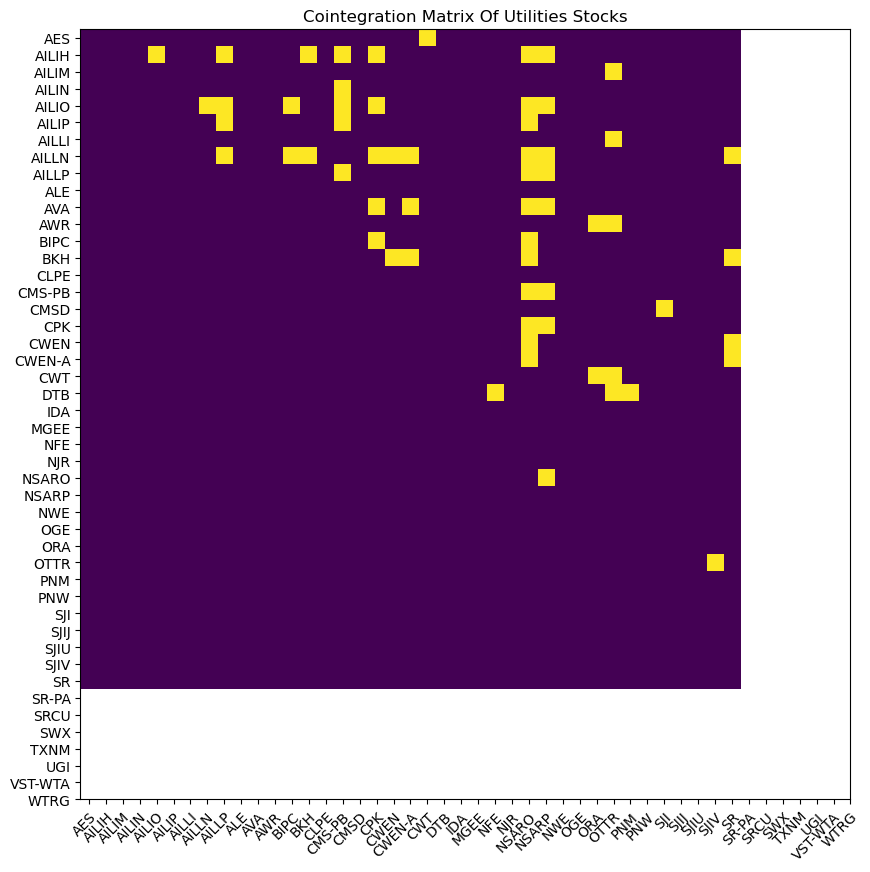

In [27]:
# Cointegration Test to find the best pairs
def cointegration_checker(stock_dataframe):
    cointegrated_pairs = []
    
    k = stock_dataframe.shape[1]
    #getting the number of columns (tickers)
    p_values = np.ones( (k, k) )
    
    
    keys = stock_dataframe.keys()
    #getting the column names (tickers) from df
    
    for i in range(k-1):
        for j in range(i+1, k):
            
            Asset_1 = stock_dataframe[keys[i]]
            Asset_2 = stock_dataframe[keys[j]]
            
            #iterating through the df and testing cointegration for all pairs of tickers
            if Asset_1.min() != Asset_1.max() and Asset_2.min() != Asset_2.max():
                Coint_Test = coint(Asset_1, Asset_2)
            
                pvalue = Coint_Test[1]
                # statsmodels coint returns p-values (our primary concern) in the 1th index slot
                p_values[i, j] = pvalue
                #p value matrix where the output of the coint test is the ith, jth index
                if pvalue < 0.02:
                    cointegrated_pairs.append((keys[i], keys[j], pvalue))
                
    return p_values, cointegrated_pairs

# # Display the results
pvalues, pairs = cointegration_checker(adj_close_data)

fig, ax = plt.subplots(figsize=(25, 10))
im = ax.imshow(pvalues <= .02)

ax.set_xticks(np.arange(len(Ticker_list)))
ax.set_yticks(np.arange(len(Ticker_list)))

ax.set_xticklabels(Ticker_list)
ax.set_yticklabels(Ticker_list)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title(f"Cointegration Matrix Of {stock_screener()[1]} Stocks")
plt.show()

def myfunc(n):
    return n[2]

pairs.sort(key = myfunc, reverse = True)

In [28]:
res1 = []
for i in pairs:
    placeholder, pvalue, placeholder2 = coint(adj_close_data[i[1]][0:252], adj_close_data[i[0]][0:252])
    print(f"The pvalue of the augmented Engle-Granger two-step cointegration test between {i[1]} and {i[0]} is", pvalue)

The pvalue of the augmented Engle-Granger two-step cointegration test between CMS-PB and AILLP is 0.07371939349360164
The pvalue of the augmented Engle-Granger two-step cointegration test between OTTR and DTB is 0.9481932780087082
The pvalue of the augmented Engle-Granger two-step cointegration test between CPK and AILIO is 0.12121972151041599
The pvalue of the augmented Engle-Granger two-step cointegration test between OTTR and AWR is 0.9758583432700995
The pvalue of the augmented Engle-Granger two-step cointegration test between BIPC and AILIO is 0.4752398942266764
The pvalue of the augmented Engle-Granger two-step cointegration test between ORA and AWR is 0.9490841799240323
The pvalue of the augmented Engle-Granger two-step cointegration test between UGI and OTTR is 0.49993987269967444
The pvalue of the augmented Engle-Granger two-step cointegration test between WTRG and BKH is 0.28293850048945296
The pvalue of the augmented Engle-Granger two-step cointegration test between BIPC and

### Stock Pairs Selection ###

In [29]:
res = []
def stock_pair(pairs):
    for i in range(len(pairs)):
        Asset_1 = adj_close_data[pairs[i][1]]
        Asset_2 =  adj_close_data[pairs[i][0]]
        price_ratio = Asset_1/Asset_2
        if price_ratio.isin([np.inf, -np.inf]).any():
            pass
        elif price_ratio.isna().any():
            pass
        elif price_ratio.max() == price_ratio.min():
            pass
        else:
            result_price_ratio = adfuller(price_ratio, autolag = "AIC")
        
            #Determine which of the spread or the price ratio is stationary
            const  = add_constant(Asset_1)
            results = OLS(Asset_2, const).fit()
            coef = results.params[pairs[i][1]]
            spread = Asset_2 - (coef * Asset_1)
            result_spread =adfuller(price_ratio, autolag = "AIC")
            
            lst = []
            if result_price_ratio[1] > 0.1:
                lst.append("Price Ratio is not stationary")
            else:
                lst.append("Price Ratio is stationary")
        
            if result_spread[1] > 0.1:
                lst.append("Spread is not stationary")
            else:
                lst.append("Spread is stationary")
        
            if lst[0] == "Price Ratio is not stationary":
                print(f"Since {lst[0]}, then I would suggest you choose a different pair because {lst[1]}, which makes the strategy fail as we won't be able to find their divergence at all.")
            else:
                res.append(i)
                print(f"Yes, the pair of {pairs[i][1]} and {pairs[i][0]} works well as {lst[0]} and will likely fluctuate around a mean of {price_ratio.mean()} {[i]}")
    return res

In [30]:
res = stock_pair(pairs)
res

Yes, the pair of CMS-PB and AILLP works well as Price Ratio is stationary and will likely fluctuate around a mean of 1.2082150975592831 [0]
Yes, the pair of OTTR and DTB works well as Price Ratio is stationary and will likely fluctuate around a mean of 3.90086547191743 [1]
Yes, the pair of CPK and AILIO works well as Price Ratio is stationary and will likely fluctuate around a mean of 1.5943482957183264 [2]
Since Price Ratio is not stationary, then I would suggest you choose a different pair because Spread is not stationary, which makes the strategy fail as we won't be able to find their divergence at all.
Yes, the pair of BIPC and AILIO works well as Price Ratio is stationary and will likely fluctuate around a mean of 0.5354368752404447 [4]
Yes, the pair of ORA and AWR works well as Price Ratio is stationary and will likely fluctuate around a mean of 0.9546210233398931 [5]
Since Price Ratio is not stationary, then I would suggest you choose a different pair because Spread is not stati

[0,
 1,
 2,
 4,
 5,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 21,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60]

### Graphing for chosen pair ###

In [32]:
db = trading.get_database() 
asset_db = db["Assets"] 

done = False 
chosen_lst = [] 

asset_details = asset_db.find() 
items_df = pd.DataFrame(asset_details) 

if items_df.empty:
    # If database is empty, allow any pair selection
    while not done: 
        index = int(input("Enter the index of your chosen pair please: "))
        consider = input("Do you want to reconsider your options? (y/n): ") 
        if consider.lower() == 'n': 
            done = True
else:
    # If database has existing pairs, check for duplicates
    for i in items_df['Asset1']: 
        chosen_lst.append(i) 
    
    for i in items_df['Asset2']: 
        chosen_lst.append(i) 
    
    while not done: 
        valid_pair = False
        while not valid_pair:
            index = int(input("Enter the index of your chosen pair please: ")) 
            # Check if the pair exists in MongoDB
            if (pairs[index][0], pairs[index][1]) in zip(items_df['Asset1'], items_df['Asset2']):
                print("This pair already exists. Please enter a different index.")
            else:
                valid_pair = True
                
        consider = input("Do you want to reconsider your options? (y/n): ") 
        if consider.lower() == 'n': 
            done = True
            
with open('pair.txt', 'w') as f:
    print(pairs[index][0], pairs[index][1], file=f)

Pinged your deployment. You successfully connected to MongoDB!


In [33]:
%run portfolio.ipynb
db = trading.get_database()
portfolio_db = db["Portfolio"]
# Retrieve all trading details from the database
portfolio_details = list(portfolio_db.find())

# Convert MongoDB cursor to DataFrame
portfolio_df = pd.DataFrame(portfolio_details)

# Sort DataFrame by Date in descending order and keep the first row
latest_portfolio = portfolio_df.sort_values('_id', ascending=False).iloc[0]

# Convert Series to DataFrame (corrected way)
latest_portfolio_df = pd.DataFrame([latest_portfolio])

# Delete all documents from the collection
portfolio_db.delete_many({})

# Convert to dictionary format that MongoDB expects
portfolio_dict = latest_portfolio_df.to_dict('records')[0]

# Insert only the latest portfolio data
portfolio_db.insert_one(portfolio_dict)

Pinged your deployment. You successfully connected to MongoDB!
['AMZN', 'AAPL', 'MSFT', 'GOOG', 'NVDA', 'TSM', 'IBM', 'AILLN', 'DE', 'WTRG', 'IEX', 'NSARP', 'AILIH', 'BWXT', 'BIPC', 'BKH', 'AILIO', 'CWEN', 'MAS', 'DTB', 'OTTR']


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

        HRP
CVaR : 1.42%
Mean-CVaR ratio : 0.0410


        HERC
CVaR : 1.75%
Mean-CVaR ratio : -0.0062


Pinged your deployment. You successfully connected to MongoDB!
Pinged your deployment. You successfully connected to MongoDB!


InsertOneResult(13, acknowledged=True)

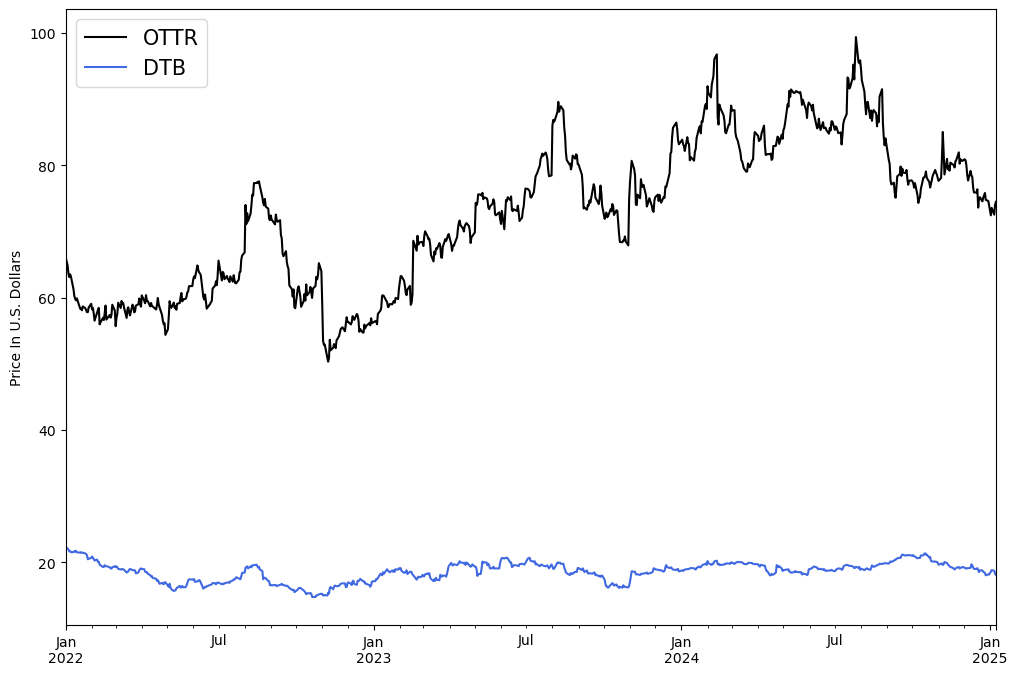

In [34]:
plt.figure(figsize=(12,8))
adj_close_data[pairs[index][1]].plot(color = 'black')
adj_close_data[pairs[index][0]].plot(color = 'royalblue')
plt.legend([pairs[index][1], pairs[index][0]], prop={'size': 15})
plt.ylabel('Price In U.S. Dollars')
plt.show()

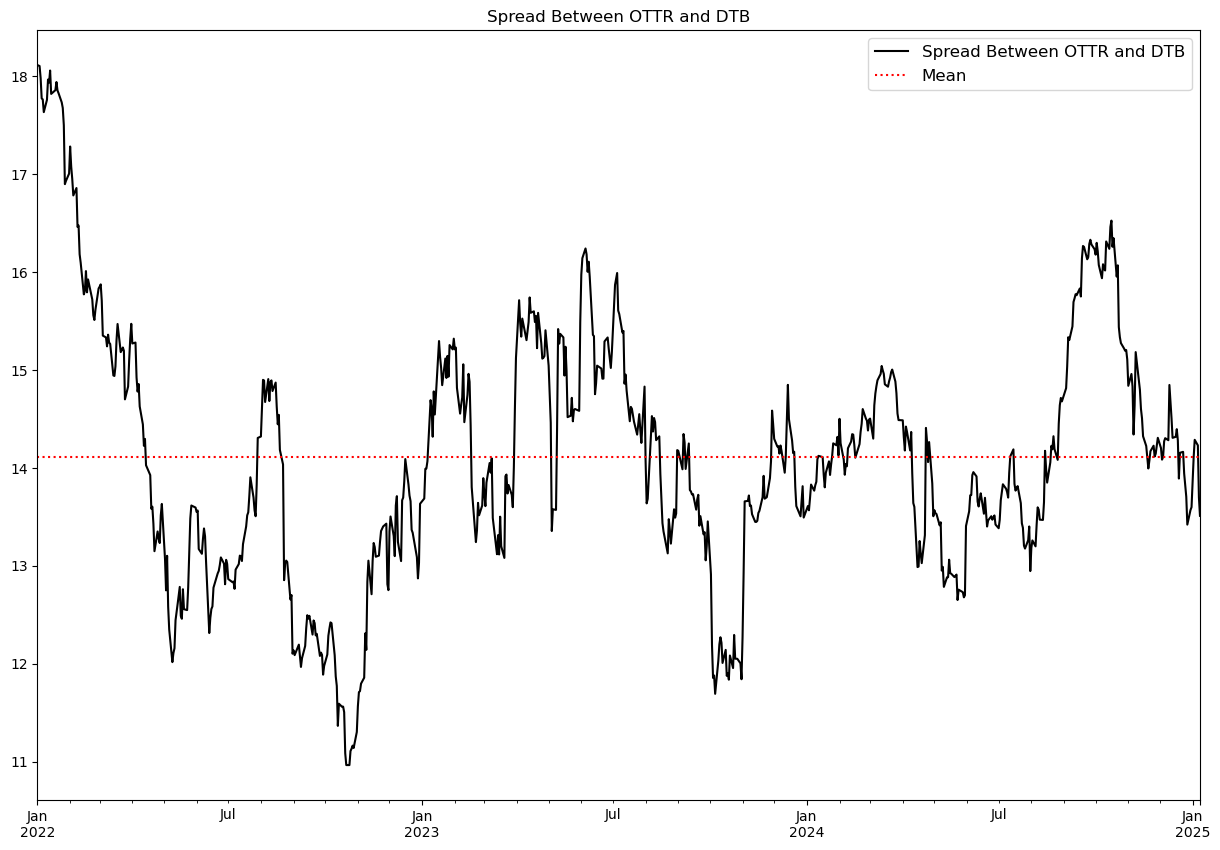

In [35]:
adj_close_data = pd.DataFrame(adj_close_data)
Asset_1 = adj_close_data[pairs[index][1]]
Asset_2 =  adj_close_data[pairs[index][0]]

#calculating the spread
Asset_1  = add_constant(Asset_1)
results = OLS(Asset_2, Asset_1).fit()

coef = results.params[pairs[index][1]]
Asset_1 = Asset_1[pairs[index][1]]

spread = Asset_2 - (coef * Asset_1)
spread.plot(figsize=(15,10), color = 'black')
begin_date = adj_close_data.index[0].strftime('%Y-%m-%d')
end_date = adj_close_data.index[len(adj_close_data.index) - 1].strftime('%Y-%m-%d')
plt.xlim(begin_date, end_date)
plt.axhline(spread.mean(), color='red', linestyle=':')
plt.legend([f"Spread Between {pairs[index][1]} and {pairs[index][0]}", 'Mean'], prop={'size': 12});
plt.title(f"Spread Between {pairs[index][1]} and {pairs[index][0]}")
plt.show()

In [36]:
# Create a list to store output containers
output_containers = []
price_ratio = Asset_1 / Asset_2
spread = Asset_1 - Asset_2  # Assuming you have defined spread elsewhere

# Create output containers for each iteration
price_ratio_output = widgets.Output()
spread_output = widgets.Output()

with price_ratio_output:
    result_price_ratio = adfuller(price_ratio, autolag="AIC")
    display(f'ADF Statistic for Price Ratio: {result_price_ratio[0]}')
    display(f'n_lags: {result_price_ratio[1]}')
    display(f'p-value: {result_price_ratio[1]}')
    for key, value in result_price_ratio[4].items():
        display('Critial Values:')
        display(f' {key}, {value}')
with spread_output:
    result_spread = adfuller(spread, autolag="AIC")
    display(f'ADF Statistic for spread: {result_spread[0]}')
    display(f'n_lags: {result_spread[1]}')
    display(f'p-value: {result_spread[1]}')
    for key, value in result_spread[4].items():
        display('Critial Values:')
        display(f' {key}, {value}')
# Append output containers to the list
output_containers.append(widgets.HBox([price_ratio_output, spread_output]))

# Display all output containers
display(widgets.VBox(output_containers))

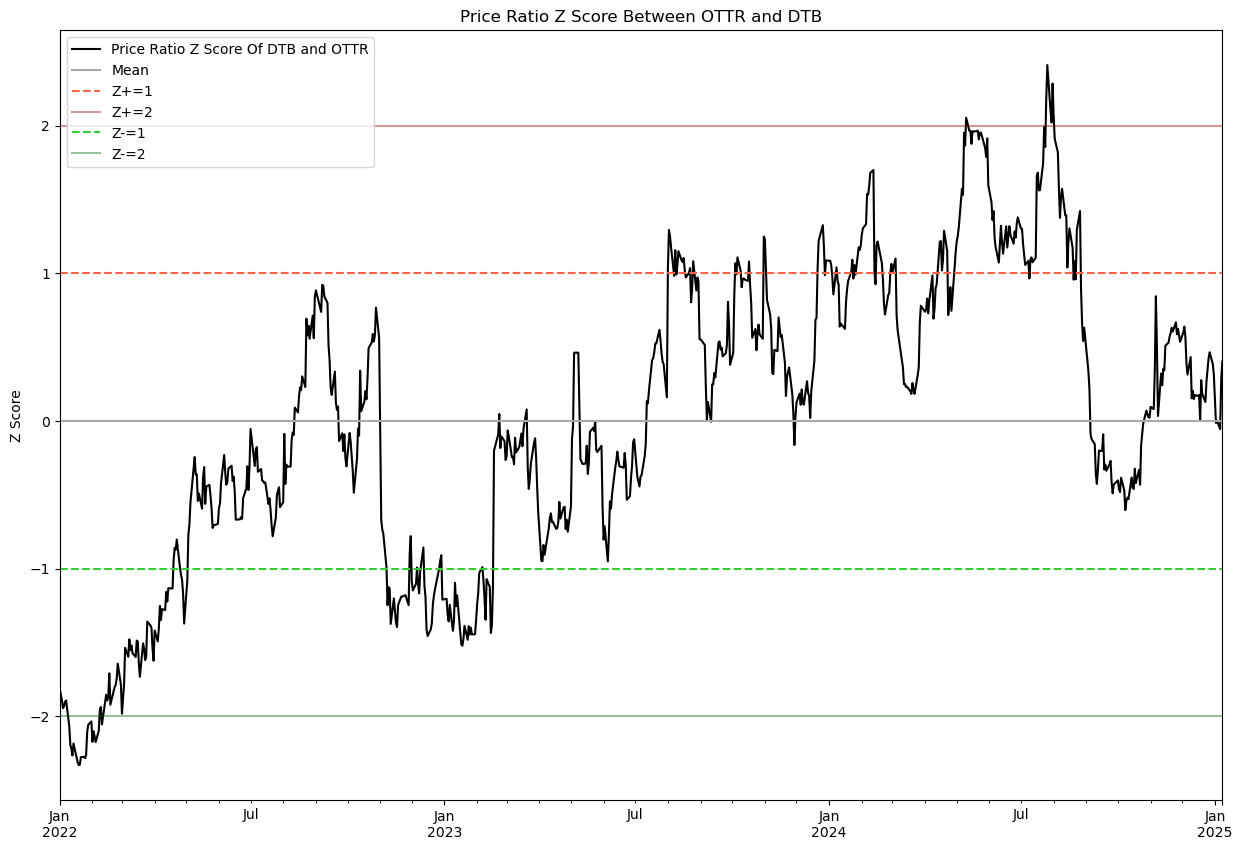

In [37]:
price_ratio_z_score = (price_ratio - price_ratio.mean()) / np.std(price_ratio)
price_ratio_z_score.plot(figsize=(15,10), color = 'black')
plt.axhline(price_ratio_z_score.mean(), color = 'darkgrey' )
plt.axhline(1, color='tomato', linestyle='dashed')
plt.axhline(2, color='darkred', alpha = .4)
plt.axhline(-1, color='limegreen', linestyle='dashed')
plt.axhline(-2, color='darkgreen', alpha = .4)
plt.xlim(begin_date, end_date)
plt.legend([f'Price Ratio Z Score Of {pairs[index][0]} and {pairs[index][1]}', 'Mean', 'Z+=1', 'Z+=2', 'Z-=1', 'Z-=2' ]);
plt.title(f"Price Ratio Z Score Between {pairs[index][1]} and {pairs[index][0]}")
plt.ylabel('Z Score')

plt.show()

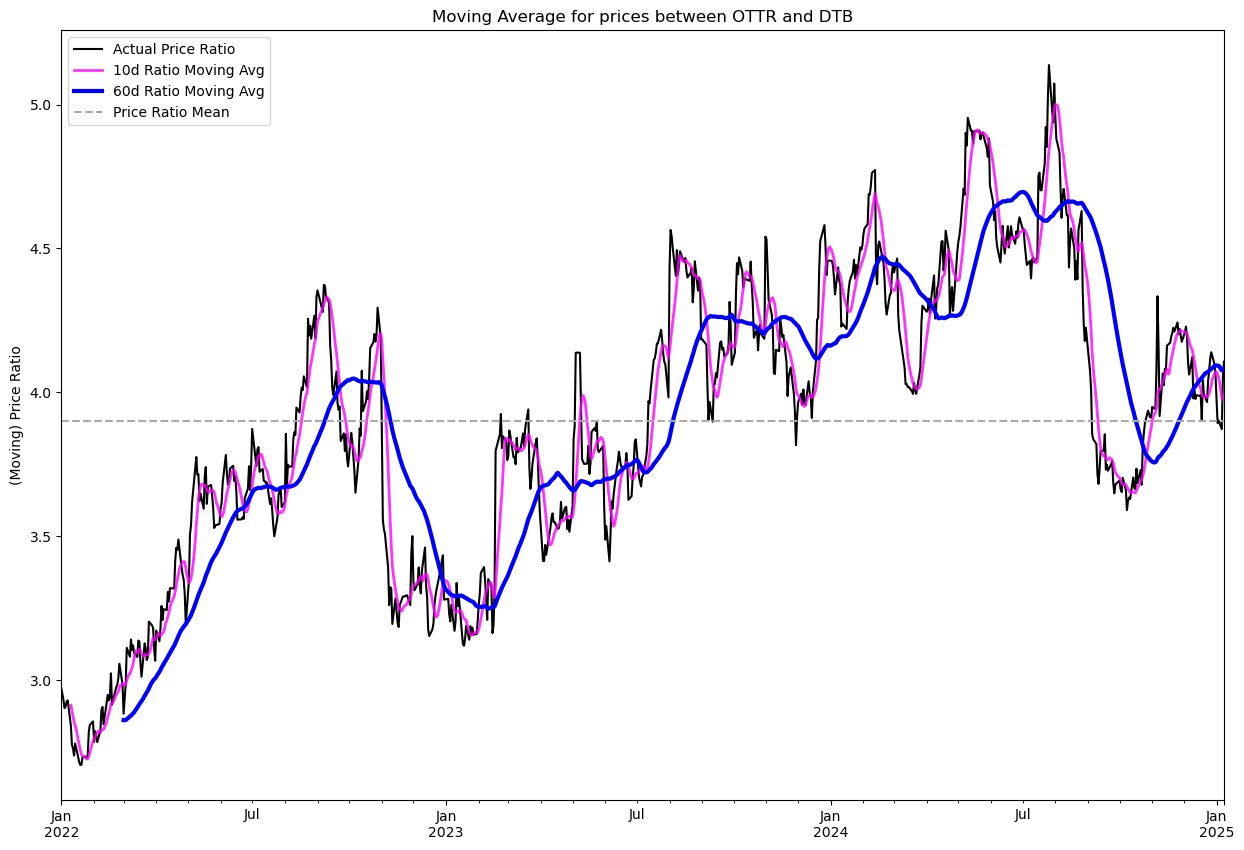

In [38]:
# Moving Averages for 10 and 60 days
price_ratio_10D_MAVG = price_ratio.rolling(window=10, center = False).mean() 
price_ratio_60D_MAVG = price_ratio.rolling(window=60, center = False).mean() 

plt.figure(figsize=(15, 10))
price_ratio.plot(color = 'black')
price_ratio_10D_MAVG.plot(color = 'magenta', linewidth=2, alpha = .8)
price_ratio_60D_MAVG.plot(color = 'b', linewidth=3)
plt.axhline(price_ratio.mean(), color = 'darkgrey', linestyle = 'dashed' )
plt.legend(['Actual Price Ratio', '10d Ratio Moving Avg', '60d Ratio Moving Avg', 'Price Ratio Mean'])
plt.title(f"Moving Average for prices between {pairs[index][1]} and {pairs[index][0]}")
plt.ylabel('(Moving) Price Ratio')
plt.show()

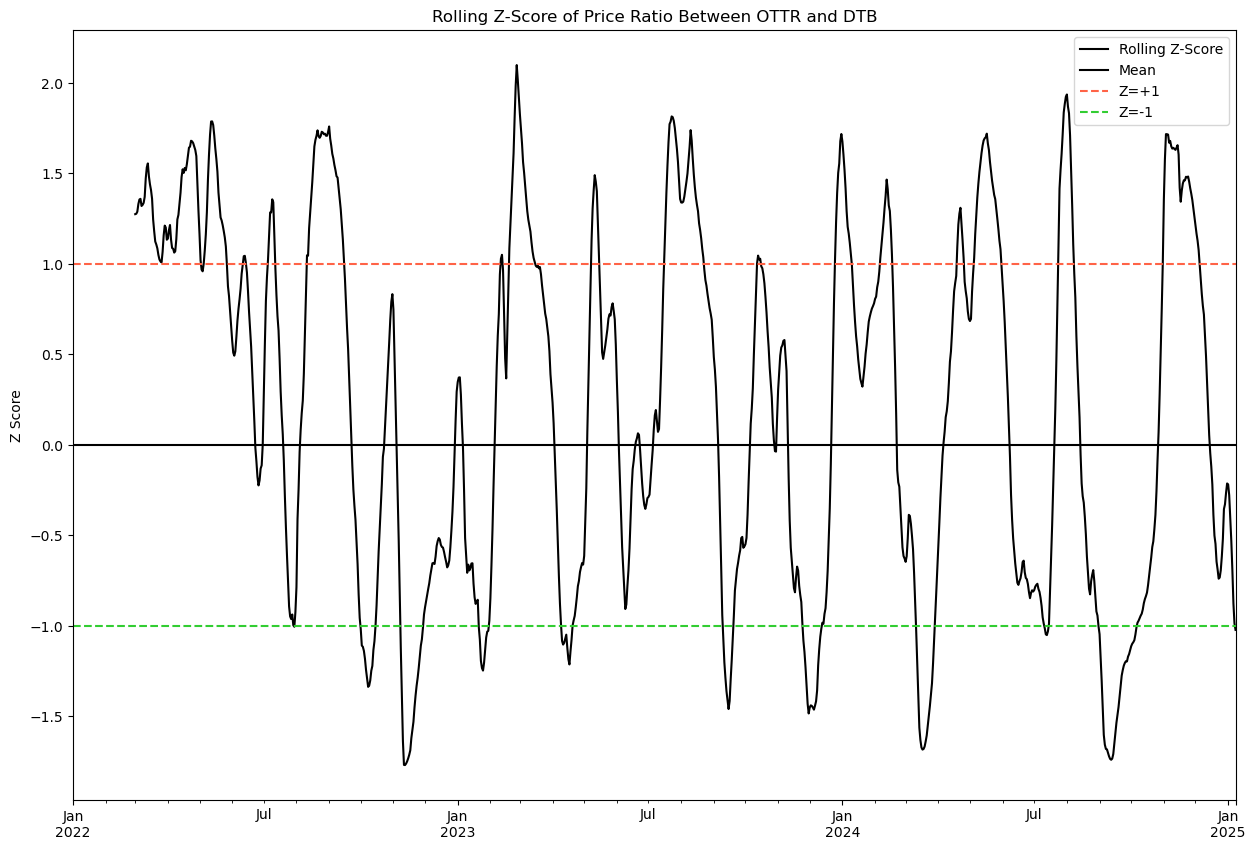

In [39]:
STD_60 = price_ratio.rolling(window=60, center = False).std()
Rolling_Z_Score = ((price_ratio_10D_MAVG - price_ratio_60D_MAVG)/STD_60)
Rolling_Z_Score.plot(figsize=(15,10), color = 'black')

plt.xlim(begin_date, end_date)
plt.axhline(0, color='black')
plt.axhline(1, color='tomato', linestyle='dashed')
plt.axhline(-1, color='limegreen', linestyle='dashed')
plt.legend(['Rolling Z-Score', 'Mean', 'Z=+1', 'Z=-1'])
plt.title(f"Rolling Z-Score of Price Ratio Between {pairs[index][1]} and {pairs[index][0]}")
plt.ylabel('Z Score')
plt.show()

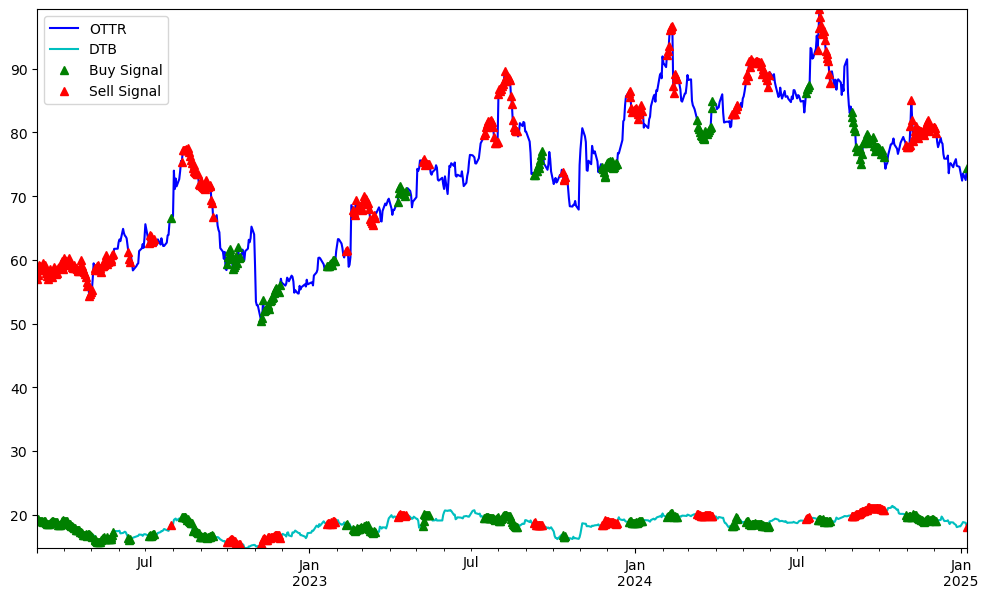

In [40]:
plt.figure(figsize=(12,7))
buy = price_ratio.copy()
sell = price_ratio.copy()
buy[Rolling_Z_Score>-1] = 0
sell[Rolling_Z_Score<1] = 0
S1 = Asset_1
S2 = Asset_2

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
plt.legend([pairs[index][1], pairs[index][0], 'Buy Signal', 'Sell Signal'])
plt.show()

## Trading Operations ###

### Kalman Filter for smooth signalling ###

In [41]:
# Kalman Filter for Pair Trading: avoid Moving Average and have better estimate of z_score
class MyKalmanFilter:
    def __init__(self, delta=1e-4, R=1e-3):
        # measurement noise variance
        self.R = R

        # co-variance of process noise(2 dimensions)
        self.Q = delta / (1-delta) * np.eye(2)

        # state (slope, intercept) will be (2 x n), we will initialize with just one column at first
        self.x = np.zeros((2, 1))     

        # state covariance
        self.P = np.zeros((2,2))     

    def step_forward(self, y1, y2):
        # Before entering the equations, let's define H as (1, 2) matrix
        H = np.array([y2, 1])[None]
        # and define z
        z = y1

        ## TIME UPDATE ##
        # first thing is to predict new state as the previous one (2x1)
        x_hat = self.x[:, -1][..., None]

        # then, the uncertainty or covariance prediction 
        P_hat = self.P + self.Q

        ## MEASUREMENT UPDATE ##
        # calc the Kalman gain
        K = P_hat.dot(H.T)/(H.dot(P_hat.dot(H.T))+self.R)

        # state update part 1 (measurement estimation)
        z_hat = H.dot(x_hat)
        # state update part 2
        x = x_hat + K.dot(z-z_hat)

        # uncertainty update
        self.P = (np.eye(2)-K.dot(H)).dot(P_hat)

        # append the new state to the vector
        self.x = np.concatenate([self.x, x], axis=1)

        return x, P_hat, K, z_hat

### Pair Trading simulation ###

In [42]:
# Alpaca API credentials
api_key = "PK6C0PCT93WSHQAL6F5J"
api_secret = "zd1UM5sEvU0d8Ur0flpklrltnv7SLGdf16sztp8d"
base_url = "https://paper-api.alpaca.markets"

# Initialize trading client
trading_client = TradingClient(api_key, api_secret, paper=True)

# Get our account information.
account = trading_client.get_account()

# Check if our account is restricted from trading.
if account.trading_blocked:
    print('Account is currently restricted from trading.')

# Check how much money we can use to open new positions.
print('${} is available as buying power.'.format(account.buying_power))

$125713.6 is available as buying power.


In [43]:
# Pair Trading Simulation
def trading_simulation(Asset1, Asset2, window1, window2, stop_loss, Kalman_Filter):
    # calculating the z score with moving averages as shown in previous sections
    price_ratio = Asset1/Asset2
    moving_average1 = price_ratio.rolling(window=window1).mean()
    moving_average2 = price_ratio.rolling(window=window2).mean()
    std = price_ratio.rolling(window=window2).std()
    z_score = ((moving_average1-moving_average2)/std)
    
    # Decide whether to use Kalmin Filter or not
    if Kalman_Filter == False:
        Kalman = z_score
    else:
        z_score = Kalman = pd.Series(series)
        # Reset index  
        Kalman.reset_index(drop=True, inplace=True)

        # Set index to match series1
        Kalman.index = z_score.index
    
    profit, profit_high, profit_low = 0,0,0
    ratio_high_sell, ratio_high_buy, ratio_low_buy, ratio_low_sell = 0, 0, 0, 0
    low_trade_total, high_trade_total, = 0,0
    count_high, count_low = 0,0
    old_profit_high, old_profit_low = 0,0
    high_hit_rate, low_hit_rate = [], []
    low_dic, high_dic = {}, {}
    Asset1_shares, Asset2_shares = 0,0
    open_trade = 0
    potential_loss_high, potential_loss_low  = 0,0
    
    # Initialize trading log
    trading_log = pd.DataFrame(columns=['Date', 'Asset', 'Action', 'Price', 'Quantity', 'Trade_Type'])
    
    for i in range(len(price_ratio)):
        date = Asset1.index[i]
        if Kalman.loc[i] > 1.25 and open_trade == 0: 
        #if the price ratio z score is high we will 'sell' the ratio 
        
            #calculating the maximum number of shares for each stock; positions are weighted equally
            Asset1_shares = portfolio_df[pairs[index][1]].iloc[-1] * float(account.buying_power) * 0.1  // Asset1.iloc[i]
            Asset2_shares = portfolio_df[pairs[index][0]].iloc[-1] * float(account.buying_power) * 0.1  // Asset2.iloc[i]
            
            
            #selling the ratio means you sell the higher stock (STT) and buy the lower stock (C)
            ratio_high_sell = Asset1.iloc[i] * Asset1_shares
            ratio_high_buy = Asset2.iloc[i] * Asset2_shares
            
            #tracking the number of trades for profit calculation and overall frequency
            count_high += 1
            high_trade_total +=1
            #checker count high with tracker
            open_trade = 1

            # Log trade
            trading_log = pd.concat([trading_log, pd.DataFrame([
                {'Date': date, 'Asset': pairs[index][1], 'Action': 'Sell', 'Price': Asset1.iloc[i], 'Quantity': Asset1_shares, 'Trade_Type': 'High'},
                {'Date': date, 'Asset': pairs[index][0], 'Action': 'Buy', 'Price': Asset2.iloc[i], 'Quantity': Asset2_shares, 'Trade_Type': 'High'}
            ])])

##############################################################################################################################            
        elif Kalman.iloc[i] < -1.25 and open_trade == 0:
        #if the price ratio z score is low we will 'buy' the ratio 
        
            #calculating the maximum number of shares for each stock; positions are weighted equally
            Asset1_shares = latest_portfolio_df[pairs[index][1]].iloc[-1] * 1000000 // Asset1.iloc[i]
            Asset2_shares = latest_portfolio_df[pairs[index][0]].iloc[-1] * 1000000 // Asset2.iloc[i]
            
            #'Buying' the ratio means you buy the higher stock (STT) and sell the lower stock (C)
            ratio_low_buy = Asset1.iloc[i] * Asset1_shares
            ratio_low_sell = Asset2.iloc[i] * Asset2_shares
            
            count_low += 1
            low_trade_total +=1
            open_trade = 1

            # Log trade
            trading_log = pd.concat([trading_log, pd.DataFrame([
                {'Date': date, 'Asset': pairs[index][1], 'Action': 'Buy', 'Price': Asset1.iloc[i], 'Quantity': Asset1_shares, 'Trade_Type': 'Low'},
                {'Date': date, 'Asset': pairs[index][0], 'Action': 'Sell', 'Price': Asset2.iloc[i], 'Quantity': Asset2_shares, 'Trade_Type': 'Low'}
            ])])

##############################################################################################################################            
        if open_trade == 1 and (abs(Kalman.iloc[i]) > .5):

            potential_loss_high = ((ratio_high_sell - (Asset1.iloc[i] * Asset1_shares * count_high)) + ((Asset2.iloc[i]*Asset2_shares*count_high) - ratio_high_buy))
            potential_loss_low = (((Asset1.iloc[i]*Asset1_shares*count_low) - ratio_low_buy) + (ratio_low_sell - (Asset2.iloc[i]*Asset2_shares*count_low)))
            #tracking the current profit from high / low positions 
            
            if potential_loss_high < -stop_loss or potential_loss_low < -stop_loss:
            # if potential losses exceed stop loss then we will cut the positions
            
                old_profit_high = profit_high
                old_profit_low = profit_low
                profit_high += ratio_high_sell - (Asset1.iloc[i] * Asset1_shares * count_high)
                profit_high += (Asset2.iloc[i]*Asset2_shares*count_high) - ratio_high_buy
            
                if (profit_high-old_profit_high) != 0:
                    high_hit_rate.append(profit_high-old_profit_high)
                    high_dic[Asset1.index[i].strftime('%Y-%m-%d')] = (profit_high-old_profit_high)
                
                profit_low += (Asset1.iloc[i]*Asset1_shares*count_low) - ratio_low_buy
                profit_low += ratio_low_sell - (Asset2.iloc[i]*Asset2_shares*count_low)
                
                if (profit_low-old_profit_low) != 0:
                    low_hit_rate.append(profit_low-old_profit_low)
                    low_dic[Asset1.index[i].strftime('%Y-%m-%d')] = (profit_low-old_profit_low)
            
                ratio_high_sell, ratio_high_buy, ratio_low_buy, ratio_low_sell = 0, 0, 0, 0
                count_high,count_low = 0,0
                open_trade = 0
                
                # Log trade
                trading_log = pd.concat([trading_log, pd.DataFrame([
                    {'Date': date, 'Asset': pairs[index][1], 'Action': 'Buy', 'Price': Asset1.iloc[i], 'Quantity': Asset1_shares, 'Trade_Type': 'Close'},
                    {'Date': date, 'Asset': pairs[index][0], 'Action': 'Buy', 'Price': Asset2.iloc[i], 'Quantity': Asset2_shares, 'Trade_Type': 'Close'}
                ])])
        
        elif (abs(Kalman.iloc[i]) < .5):
        #once the z score has returned to 'normal' we will close our positions
            
            #tracking the previous profit level so that we can calculate changes
            old_profit_high = profit_high
            old_profit_low = profit_low
            
            
            profit_high += ratio_high_sell - (Asset1.iloc[i] * Asset1_shares * count_high)
            profit_high += (Asset2.iloc[i]*Asset2_shares*count_high) - ratio_high_buy
            # profit is derived from (shorted share price - current price) + (current share price - initial long share price)
            
            if (profit_high-old_profit_high) != 0:
            #tracking profit from high trades for metrics
                high_hit_rate.append(profit_high-old_profit_high)
                high_dic[Asset1.index[i].strftime('%Y-%m-%d')] = (profit_high-old_profit_high)
                
            profit_low += (Asset1.iloc[i]*Asset1_shares*count_low) - ratio_low_buy
            profit_low += ratio_low_sell - (Asset2.iloc[i]*Asset2_shares*count_low)
                
            if (profit_low-old_profit_low) != 0:
            #tracking profit from low trades for metrics
                low_hit_rate.append(profit_low-old_profit_low)
                low_dic[Asset1.index[i].strftime('%Y-%m-%d')] = (profit_low-old_profit_low)
            
            #clearing all positions
            ratio_high_sell, ratio_high_buy, ratio_low_buy, ratio_low_sell = 0, 0, 0, 0
            count_high,count_low = 0,0
            open_trade = 0

            # Log trade
            trading_log = pd.concat([trading_log, pd.DataFrame([
                {'Date': date, 'Asset': pairs[index][1], 'Action': 'Sell', 'Price': Asset1.iloc[i], 'Quantity': Asset1_shares, 'Trade_Type': 'Close'},
                {'Date': date, 'Asset': pairs[index][0], 'Action': 'Sell', 'Price': Asset2.iloc[i], 'Quantity': Asset2_shares, 'Trade_Type': 'Close'}
            ])])
            
            
    profit = profit_low + profit_high

    if high_hit_rate != []:
        high_biggest_loss = abs(min(high_hit_rate))
        high_biggest_gain = max(high_hit_rate)

    if low_hit_rate != []:
        low_biggest_loss = abs(min(low_hit_rate))
        low_biggest_gain = max(low_hit_rate)
    
    trades_list = high_hit_rate + low_hit_rate
    
    high_list = high_hit_rate
    low_list = low_hit_rate
    
    high_hit_rate = (len([x for x in high_hit_rate if x > 0]) / len(high_hit_rate)) * 100
    low_hit_rate = (len([x for x in low_hit_rate if x > 0]) / len(low_hit_rate)) * 100
    
    print("The total profit between {} and {} was ${:.2f}".format(Asset1.index[0].strftime('%Y-%m-%d'), Asset1.index[len(Asset1)-1].strftime('%Y-%m-%d'), profit ))
    
    print("{} trades where the price ratio was high were executed; they were profitable {:.2f}% of the time, with a largest single gain of ${:.2f}, and a largest single loss of ${:.2f}"
           .format(high_trade_total, high_hit_rate, high_biggest_gain, high_biggest_loss))
    print("{} trades where the price ratio was low were executed they were profitable {:.2f}% of the time, with a largest single gain of ${:.2f}, and a largest single loss of ${:.2f}"
           .format(low_trade_total, low_hit_rate, low_biggest_gain, low_biggest_loss))
        
    trades_dic = {**high_dic, **low_dic}
    #trades_dic = sorted(trades_dic.keys())
    total = portfolio_df[pairs[index][1]].values[0] * 1000000 + portfolio_df[pairs[index][0]].values[0] * 1000000
    tracker = []
    for key, value in sorted(trades_dic.items()):
        total += trades_dic[key]
        tracker.append(total)
        
    trades = pd.DataFrame({'Date': list(trades_dic.keys()), 'Profit':list(trades_dic.values()) })
    growth_tracker = pd.DataFrame({'Date': sorted(list(trades_dic.keys())), 'Cumulative Value': tracker})
    growth_tracker = growth_tracker.set_index('Date')
    return ("High Trades", high_dic), ("Low Trades", low_dic), growth_tracker, ("Total Profit:", profit), trades, trading_log
    

### Prophet Time Series Model ###

09:11:53 - cmdstanpy - INFO - Chain [1] start processing
09:11:53 - cmdstanpy - INFO - Chain [1] done processing
09:11:55 - cmdstanpy - INFO - Chain [1] start processing
09:11:55 - cmdstanpy - INFO - Chain [1] done processing
09:11:57 - cmdstanpy - INFO - Chain [1] start processing
09:11:57 - cmdstanpy - INFO - Chain [1] done processing
09:12:00 - cmdstanpy - INFO - Chain [1] start processing
09:12:00 - cmdstanpy - INFO - Chain [1] done processing
09:12:02 - cmdstanpy - INFO - Chain [1] start processing
09:12:02 - cmdstanpy - INFO - Chain [1] done processing
09:12:04 - cmdstanpy - INFO - Chain [1] start processing
09:12:04 - cmdstanpy - INFO - Chain [1] done processing
09:12:06 - cmdstanpy - INFO - Chain [1] start processing
09:12:06 - cmdstanpy - INFO - Chain [1] done processing
09:12:08 - cmdstanpy - INFO - Chain [1] start processing
09:12:09 - cmdstanpy - INFO - Chain [1] done processing
09:12:11 - cmdstanpy - INFO - Chain [1] start processing
09:12:11 - cmdstanpy - INFO - Chain [1]

The total profit between 2022-01-01 and 2026-01-08 was $16264.80
54 trades where the price ratio was high were executed; they were profitable 48.15% of the time, with a largest single gain of $35.50, and a largest single loss of $64.01
63 trades where the price ratio was low were executed they were profitable 58.73% of the time, with a largest single gain of $6742.45, and a largest single loss of $4698.67


(('High Trades',
  {'2022-01-03': 5.689599999999928,
   '2022-01-29': -3.8774000000000797,
   '2022-02-09': -1.476099999999974,
   '2022-02-19': 14.343800000000044,
   '2022-03-26': 0.9607999999999493,
   '2022-04-09': -1.0586999999999875,
   '2022-04-21': -6.010999999999967,
   '2022-05-21': 4.029799999999966,
   '2022-07-02': -9.662599999999998,
   '2022-07-27': -2.4302999999999315,
   '2022-08-05': 12.413599999999917,
   '2022-08-11': 0.3808999999999969,
   '2022-08-13': 0.8514000000000124,
   '2022-08-27': 4.65160000000003,
   '2022-09-08': -1.3985999999999876,
   '2022-10-12': 0.9304000000000201,
   '2022-10-15': 15.19380000000001,
   '2022-10-22': -0.6023000000000138,
   '2022-10-29': 3.9855000000000587,
   '2022-12-03': 21.756799999999885,
   '2022-12-10': -3.994899999999973,
   '2023-01-18': 35.50409999999994,
   '2023-02-04': -1.6920000000000641,
   '2023-02-18': -64.01320000000004,
   '2023-02-25': 10.218399999999917,
   '2023-03-03': 4.964399999999955,
   '2023-03-11': 1.626

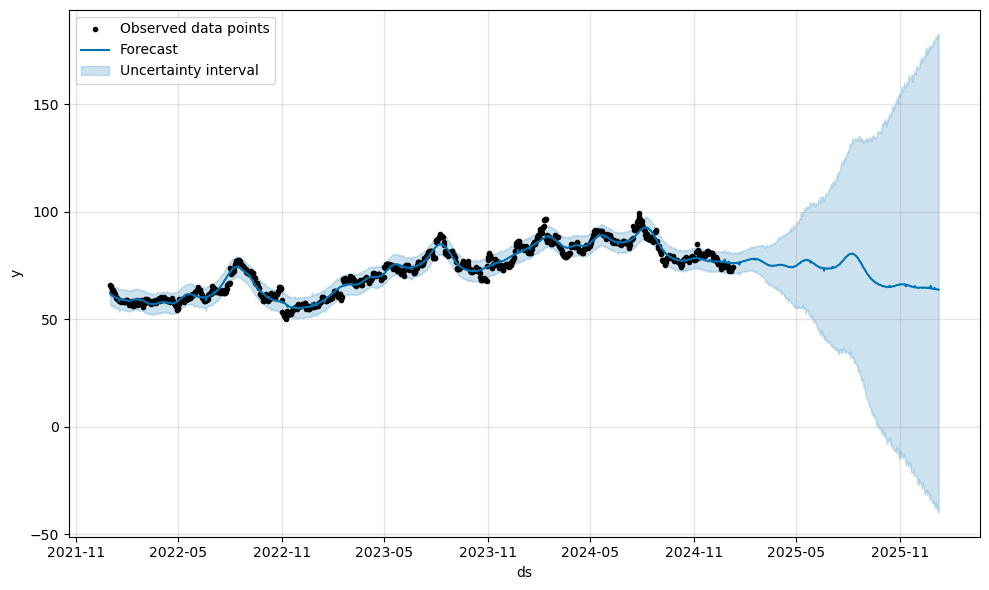

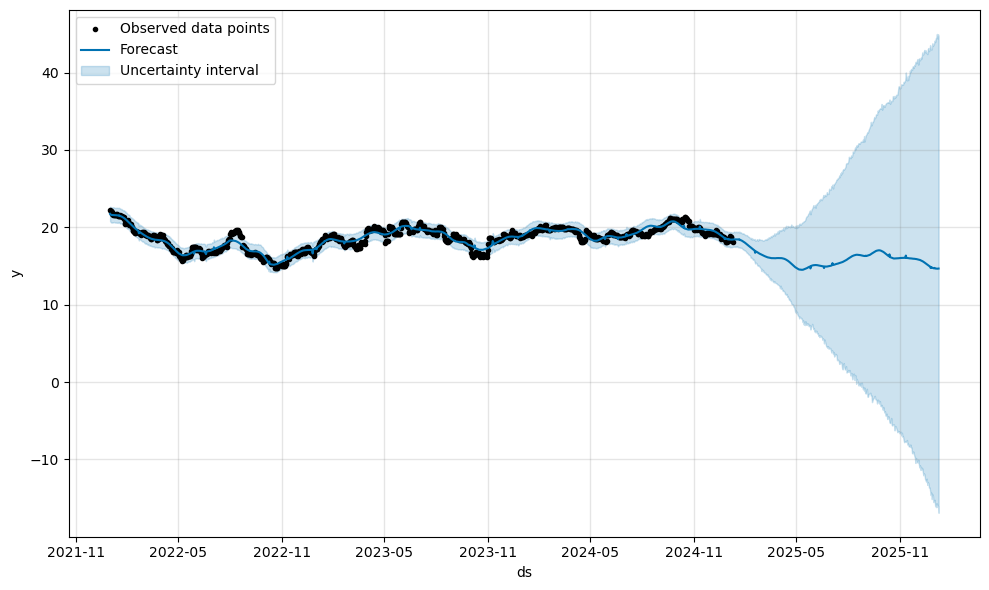

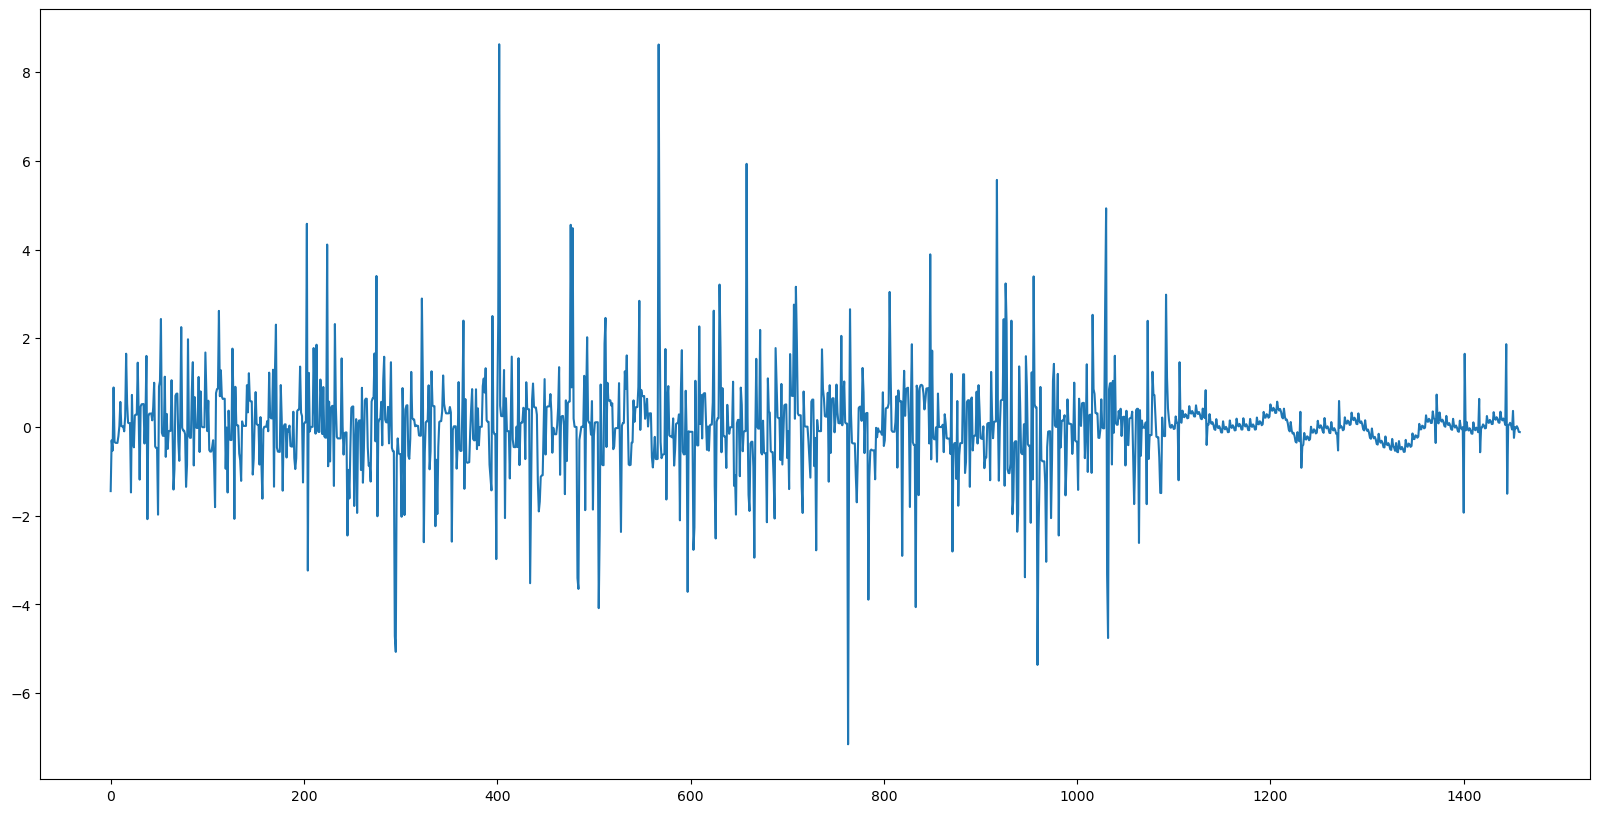

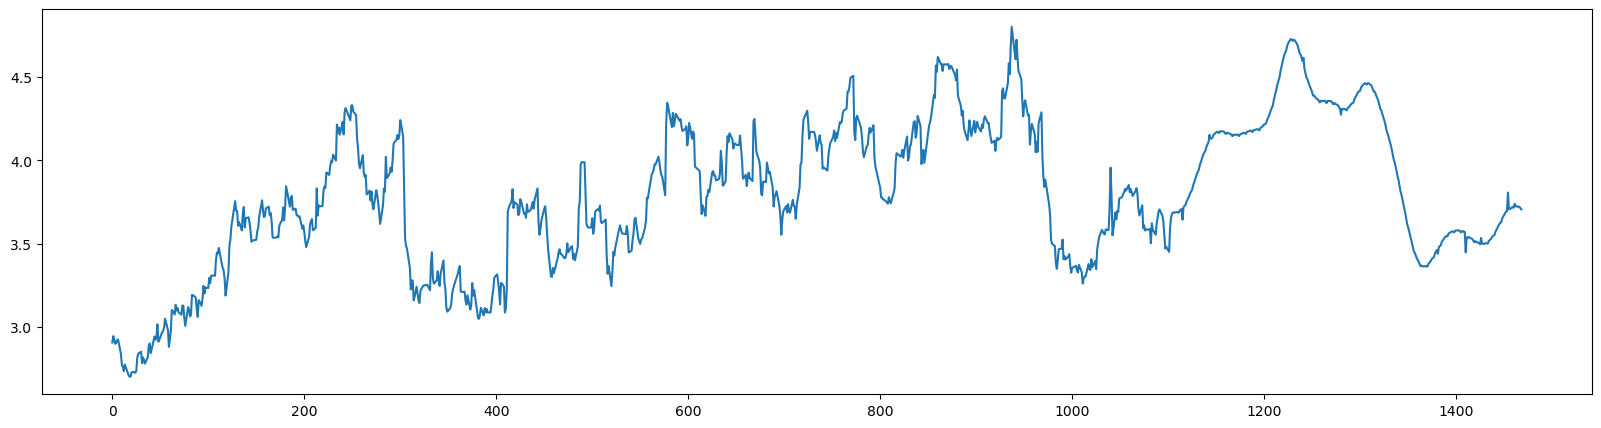

In [44]:
def train_prophet_model(data):
    # if data.equals(first_stock_data) == True:
    model = Prophet(
        interval_width=0.95,
        changepoint_prior_scale= best_params['changepoint_prior_scale'],
        holidays_prior_scale=15,
        seasonality_prior_scale= best_params['seasonality_prior_scale'],
        weekly_seasonality= True,
        yearly_seasonality= True,
        daily_seasonality=False,
    )
    model.add_country_holidays(country_name="US")
    model.fit(data)
    return model

def generate_forecast(model, periods=365):
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    return forecast


def plot_forecast(model, forecast):
    model.plot(forecast, include_legend = True)

adj_close_data.reset_index(inplace=True)
adj_close_data.rename(columns={"index":"ds"},inplace=True)
# Extract the data of the 2 stocks in the pair individually
first_stock_data = adj_close_data[['ds', pairs[index][1]]]
second_stock_data = adj_close_data[['ds',pairs[index][0]]]

# Rename the stock price column to y
first_stock_data.rename(columns={pairs[index][1]:"y"},inplace=True)
second_stock_data.rename(columns={pairs[index][0]:"y"},inplace=True)
first_stock_data['ds'] = first_stock_data['ds'].dt.to_timestamp()
second_stock_data['ds'] = second_stock_data['ds'].dt.to_timestamp()

# Fine-Tuning Hyperparameter for the Prophet prediction model
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(first_stock_data)  # Fit model with given params
    df_cv = cross_validation(m, initial= f'{int(len(adj_close_data) * 70/100)} days', period= f'{int(len(adj_close_data) * 70/600)} days', horizon= f'{int(len(adj_close_data) * 70/300)} days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

# Generate all combinations of parameters
all_params1 = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses1 = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params1:
    m = Prophet(**params).fit(second_stock_data)  # Fit model with given params
    # df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days', parallel="processes")
    df_cv = cross_validation(m, initial= f'{int(len(adj_close_data) * 70/100)} days', period= f'{int(len(adj_close_data) * 70/600)} days', horizon= f'{int(len(adj_close_data) * 70/300)} days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses1.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results1 = pd.DataFrame(all_params1)
tuning_results1['rmse'] = rmses1

best_params = all_params[np.argmin(rmses)]
best_params1 = all_params1[np.argmin(rmses1)]

#Train Prophet model
first_model = train_prophet_model(first_stock_data)

# Generate forecast
first_forecast = generate_forecast(first_model)

#plot_forecast(first_model, first_forecast)

#Train Prophet model
second_model = train_prophet_model(second_stock_data)

# Generate forecast
second_forecast = generate_forecast(second_model)

# Plot forecast
model_list = []
model_list.append(first_model)
model_list.append(second_model)

forecast_list = []
forecast_list.append(first_forecast)
forecast_list.append(second_forecast)

for j in zip(model_list, forecast_list):
    plot_forecast(j[0], j[1])

# Filling out predicted to observed data for each pair
# Reset index
first_stock_data = first_stock_data.set_index('ds')

# Filter out future prices from known ones
rslt_df = first_forecast[first_forecast['ds'] > end_date] 
rslt_df = rslt_df.set_index('ds')
rslt_df = rslt_df['yhat']
result = first_stock_data['y']._append(rslt_df)
result.index.to_period("D")

second_stock_data = second_stock_data.set_index('ds')

# Filter out future prices from known ones
rslt_df1 = second_forecast[second_forecast['ds'] > end_date] 
rslt_df1= rslt_df1.set_index('ds')
rslt_df1 = rslt_df1['yhat']
result1 = second_stock_data['y']._append(rslt_df1)
result1.index.to_period("D")

mkf = MyKalmanFilter(delta=1e-4, R=1e-3)
series = []
# Create a new DataFrame
df = pd.DataFrame({
    pairs[0][1]: result,
    pairs[0][0]: result1
})
for idx, row in df.iterrows():
    x, P, K, z_hat = mkf.step_forward(row[pairs[0][1]], row[pairs[0][0]])
    series.append(row[pairs[0][1]] - z_hat.squeeze())

# Plot the combined portfolio
plt.figure(figsize=(20,10))
plt.plot(series[10:])

# Plot the hedge ratio over time
plt.figure(figsize=(20,5))
plt.plot(mkf.x[0, 1:])

Kalman_Filter = True
trading_simulation(result, result1, 10, 60, 5000, Kalman_Filter)


In [45]:
trade_log = trading_simulation(result, result1, 10, 60, 50000, Kalman_Filter)[5]
trade_log

C:\Users\buitu\AppData\Local\Temp\ipykernel_156948\3147555963.py:56: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



The total profit between 2022-01-01 and 2026-01-08 was $16264.80
54 trades where the price ratio was high were executed; they were profitable 48.15% of the time, with a largest single gain of $35.50, and a largest single loss of $64.01
63 trades where the price ratio was low were executed they were profitable 58.73% of the time, with a largest single gain of $6742.45, and a largest single loss of $4698.67


,Date,Asset,Action,Price,Quantity,Trade_Type
0,2022-01-01,OTTR,Sell,65.9784,7.0,High
1,2022-01-01,DTB,Buy,22.2079,27.0,High
0,2022-01-03,OTTR,Sell,64.8605,7.0,Close
1,2022-01-03,DTB,Sell,22.1288,27.0,Close
0,2022-01-05,OTTR,Sell,63.0997,7.0,Close
...,...,...,...,...,...,...
1,2026-01-06,DTB,Sell,14.651289499278215,40.0,Close
0,2026-01-07,OTTR,Sell,63.836848271830405,7.0,Close
1,2026-01-07,DTB,Sell,14.665216182278769,40.0,Close
0,2026-01-08,OTTR,Sell,63.7452588345885,7.0,Close


In [46]:
item = {
      "Sector" : stock_screener()[1],
      "Size" : stock_screener()[2],
      'Asset1': pairs[index][0],
      'Asset2': pairs[index][1]
}
if asset_db.find_one(item):
      print(False)
else:
      asset_db.insert_many([item])
      
asset_details = asset_db.find()
items_df = pd.DataFrame(asset_details)
print(items_df)

                         _id       Sector       Size Asset1 Asset2
0   676f305046125ac4d10319ac    Utilities    Mid Cap   CWEN   WTRG
1   676f3b0746125ac4d10319b3    Utilities    Mid Cap  AILIH    BKH
2   676f44f33eb99421f0ea4397    Utilities    Mid Cap  AILIO   BIPC
3   677087c399737d52fadbbd78  Industrials  Large Cap   BWXT    MAS
4   6770899f99737d52fadbbd80    Utilities    Mid Cap  AILIO  AILLN
5   67708d59688af994da22080e    Utilities    Mid Cap  AILLN  NSARP
6   6770b4d595219198ca3cd2d8  Industrials  Large Cap     DE    IEX
7   6771aa46e613a46133b99bb4    Utilities    Mid Cap   BIPC  NSARP
8   67772e540059d20eaae1129c    Materials  Large Cap    PPG    WLK
9   677ca1ac3c26753234edbaf5    Utilities    Mid Cap    AVA    CPK
10  6780823e2518802d6bd96b1c    Utilities    Mid Cap    DTB   OTTR


In [48]:
# Fetch the list of assets
assets_url = f"{base_url}/v2/assets"
headers = {
    "accept": "application/json",
    "APCA-API-KEY-ID": api_key,
    "APCA-API-SECRET-KEY": api_secret,
}
response = requests.get(assets_url, headers=headers)

if response.status_code == 200:
    assets = response.json()
    # Ensure the Date column is in datetime format
    trade_log['Date'] = pd.to_datetime(trade_log['Date'])

    # Get today's date
    today = datetime.date.today().strftime('%Y-%m-%d')

    # Filter rows where Date matches today's date
    today_row = trade_log[trade_log['Date'] == today]
    if today_row.empty:
        print('Hold, no trade')
    else:
        for i, j, k in zip(today_row['Asset'], today_row['Action'], today_row['Quantity']):
            ticker = i
            asset = next((a for a in assets if a["symbol"] == ticker), None)
            if asset:
                print(f"Ticker: {asset['symbol']}")
                print(f"Tradable: {asset['tradable']}")
                print(f"Exchange: {asset['exchange']}")
                
                if asset['tradable']:
                    if j == 'Sell' and not asset.get('shortable', False):
                        print(f"Ticker {ticker} cannot be sold short. Skipping...")
                        continue  # Skip this iteration if the asset can't be shorted

                    # Prepare and submit market order
                    market_order_data = MarketOrderRequest(
                        symbol=ticker, 
                        qty=k, 
                        side=OrderSide.BUY if j == 'Buy' else OrderSide.SELL, 
                        time_in_force=TimeInForce.GTC
                    )
                    try:
                        market_order = trading_client.submit_order(order_data=market_order_data)
                        print("Market order submitted:", market_order)
                    except Exception as e:
                        print(f"Error submitting market order for {ticker}: {e}")
                else:
                    print(f"Ticker {ticker} is not tradable.")
            else:
                print(f"The ticker {ticker} is not found.")
else:
    print(f"Error fetching assets: {response.status_code}, {response.text}")

# Get a list of all of our positions.
portfolio = trading_client.get_all_positions()

# Print the quantity of shares for each position.
for position in portfolio:
    print("{} shares of {}".format(position.qty, position.symbol))

Ticker: OTTR
Tradable: True
Exchange: NASDAQ
Market order submitted: id=UUID('a7358454-ed38-4e1d-b8d9-a3050ded2678') client_order_id='44e40a98-087a-4ec1-826a-f7e74e4a7c30' created_at=datetime.datetime(2025, 1, 10, 2, 43, 47, 897352, tzinfo=TzInfo(UTC)) updated_at=datetime.datetime(2025, 1, 10, 2, 43, 47, 898341, tzinfo=TzInfo(UTC)) submitted_at=datetime.datetime(2025, 1, 10, 2, 43, 47, 897352, tzinfo=TzInfo(UTC)) filled_at=None expired_at=None canceled_at=None failed_at=None replaced_at=None replaced_by=None replaces=None asset_id=UUID('a1dbcc7d-ba56-486a-b53f-0402e526660f') symbol='OTTR' asset_class=<AssetClass.US_EQUITY: 'us_equity'> notional=None qty='6' filled_qty='0' filled_avg_price=None order_class=<OrderClass.SIMPLE: 'simple'> order_type=<OrderType.MARKET: 'market'> type=<OrderType.MARKET: 'market'> side=<OrderSide.SELL: 'sell'> time_in_force=<TimeInForce.GTC: 'gtc'> limit_price=None stop_price=None status=<OrderStatus.ACCEPTED: 'accepted'> extended_hours=False legs=None trail_